In [94]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from datetime import datetime
from urllib.parse import urlparse

import torch
from transformers import BertTokenizer, BertLMHeadModel

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import numpy as np
import os
nltk.download("stopwords")
from nltk.corpus import stopwords
stopword=nltk.corpus.stopwords.words('english')
nltk.download("wordnet")
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import coherencemodel
# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
import re, nltk,gensim
import warnings
warnings.filterwarnings('ignore')

import schedule
import time

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/genresell/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/genresell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/genresell/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/genresell/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /Users/genresell/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [95]:
data = []

In [96]:
def web_scraper():
    urls = [
    'https://www.wsj.com/',
    'https://www.cnn.com/',
    'https://www.nytimes.com/',
    'https://www.theguardian.com/international',
    'https://www.reuters.com/news/world'
    ]

    # Initialize an empty list to store the scraped data
    articles = []

    for url in urls:
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')
        articles += soup.find_all('article')

    for article in articles:
        article_url = article.find('a')['href']
        if not article_url.startswith('http'):
            article_url = f'https://{urlparse(url).netloc}{article_url}'

        title = article.find('h3')
        if title:
            title = title.text.strip()

        date = article.find('time')
        if date:
            try:
                date = datetime.strptime(date['datetime'], '%Y-%m-%dT%H:%M:%S.%fZ')
                date = date.strftime('%Y-%m-%d %H:%M:%S')
            except ValueError:
                date = None

        author = article.find('span', class_='c-byline__name')
        if author:
            author = author.text.strip()

        content = ''
        content_url = article_url
        content_response = requests.get(content_url)
        content_soup = BeautifulSoup(content_response.content, 'html.parser')
        paragraphs = content_soup.find_all('p')
        for paragraph in paragraphs:
            content += paragraph.text

        data.append({
            'title': title,
            'date': date,
            'author': author,
            'content': content,
            'url': article_url
        })

In [104]:
web_scraper()

In [105]:
df = pd.DataFrame(data)
print(df.tail())

                                                title  date author   
20  Harris backs expelled Tennessee lawmakers, chi...  None   None  \
21  U.S. Supreme Court Justice Thomas defends trip...  None   None   
22  Unstable markets drag Canadian M&A, debt issua...  None   None   
23  Paramount explores sale of majority stake in s...  None   None   
24  UBS CEO tells Credit Suisse staff to stay focu...  None   None   

                                              content   
20  [1/7] U.S. Vice President Kamala Harris speaks...  \
21  April 7 (Reuters) - U.S. Supreme Court Justice...   
22  TORONTO, April 6 (Reuters) - Canadian dealmake...   
23  April 7 (Reuters) - Paramount Global (PARA.O) ...   
24  [1/2] Sergio Ermotti, newly rehired CEO of UBS...   

                                                  url  
20  https://www.reuters.com/article/tennessee-poli...  
21  https://www.reuters.com/article/usa-court-just...  
22  https://www.reuters.com/article/canada-deals/u...  
23  https://

In [106]:
# load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertLMHeadModel.from_pretrained('bert-base-uncased')

If you want to use `BertLMHeadModel` as a standalone, add `is_decoder=True.`
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertLMHeadModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertLMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertLMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [107]:
# define function to preprocess text data for BERT
def preprocess_text(text):
    # tokenize text
    tokenized_text = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        truncation=True,
        max_length=127,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )

    return tokenized_text

In [108]:
# define function to generate summary using BERT
def generate_summary(text):
    # preprocess text
    tokenized_text = preprocess_text(text)

    # generate summary
    summary_ids = model.generate(
        input_ids=tokenized_text['input_ids'],
        attention_mask=tokenized_text['attention_mask'],
        max_length=128,
        num_beams=4,
        early_stopping=True
    )

    # decode summary
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    return summary

In [109]:
# preprocess content and generate summary for each article in dataframe
df['content_preprocessed'] = df['content'].apply(preprocess_text)
df['summary'] = df['content'].apply(generate_summary)

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le

In [110]:
# view final dataframe with summary column added
print(df.tail())

                                                title  date author   
20  Harris backs expelled Tennessee lawmakers, chi...  None   None  \
21  U.S. Supreme Court Justice Thomas defends trip...  None   None   
22  Unstable markets drag Canadian M&A, debt issua...  None   None   
23  Paramount explores sale of majority stake in s...  None   None   
24  UBS CEO tells Credit Suisse staff to stay focu...  None   None   

                                              content   
20  [1/7] U.S. Vice President Kamala Harris speaks...  \
21  April 7 (Reuters) - U.S. Supreme Court Justice...   
22  TORONTO, April 6 (Reuters) - Canadian dealmake...   
23  April 7 (Reuters) - Paramount Global (PARA.O) ...   
24  [1/2] Sergio Ermotti, newly rehired CEO of UBS...   

                                                  url   
20  https://www.reuters.com/article/tennessee-poli...  \
21  https://www.reuters.com/article/usa-court-just...   
22  https://www.reuters.com/article/canada-deals/u...   
23  http

In [111]:
analyzer = SentimentIntensityAnalyzer()
df['sentiment_scores'] = df['summary'].apply(lambda x: analyzer.polarity_scores(x))

In [112]:
def get_sentiment_label(compound_score):
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [113]:
df['sentiment_label'] = df['sentiment_scores'].apply(lambda x: get_sentiment_label(x['compound']))

In [114]:
# view final dataframe with sentiment scores column added
print(df.tail())

                                                title  date author   
20  Harris backs expelled Tennessee lawmakers, chi...  None   None  \
21  U.S. Supreme Court Justice Thomas defends trip...  None   None   
22  Unstable markets drag Canadian M&A, debt issua...  None   None   
23  Paramount explores sale of majority stake in s...  None   None   
24  UBS CEO tells Credit Suisse staff to stay focu...  None   None   

                                              content   
20  [1/7] U.S. Vice President Kamala Harris speaks...  \
21  April 7 (Reuters) - U.S. Supreme Court Justice...   
22  TORONTO, April 6 (Reuters) - Canadian dealmake...   
23  April 7 (Reuters) - Paramount Global (PARA.O) ...   
24  [1/2] Sergio Ermotti, newly rehired CEO of UBS...   

                                                  url   
20  https://www.reuters.com/article/tennessee-poli...  \
21  https://www.reuters.com/article/usa-court-just...   
22  https://www.reuters.com/article/canada-deals/u...   
23  http

In [115]:
# Define the sentiment analysis function
def analyze_sentiment(text):
    # Instantiate the SentimentIntensityAnalyzer from NLTK
    sia = SentimentIntensityAnalyzer()

    # Analyze the sentiment of the text
    sentiment = sia.polarity_scores(text)

    return sentiment

In [116]:
# Define the function to update the data analysis and insights
def update_insights(df):
    # Generate a summary for each article
    df["summary"] = df["content"].apply(generate_summary)

    # Analyze the sentiment of each article summary
    df["sentiment"] = df["summary"].apply(analyze_sentiment)

    # Generate insights based on the sentiment analysis
    positive_articles = df[df["sentiment"]["compound"] > 0.5]
    negative_articles = df[df["sentiment"]["compound"] < -0.5]
    neutral_articles = df[(df["sentiment"]["compound"] >= -0.5) & (df["sentiment"]["compound"] <= 0.5)]

    # Print the number of positive, negative, and neutral articles
    print("Number of positive articles: {}".format(len(positive_articles)))
    print("Number of negative articles: {}".format(len(negative_articles)))
    print("Number of neutral articles: {}".format(len(neutral_articles)))

    # Generate visualizations of the sentiment analysis results

In [117]:
import re 
def preprocess_text(text):
    text = re.sub('((www\.[^\s]+)|-(https?://[^\s]+))',' ', text)
    text = re.sub('@[^\s]+',' ', text)
    text = text.lower().replace("ё", "е")
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(r'\d+','', text)
    text = re.sub(r'\b\w{1,3}\b', '', text)
    return text.strip()

In [118]:
df["cleaned"]=df["summary"].apply(preprocess_text)

In [119]:
#Removing extra unnecessary words.
new_stopwords=['april', 'reuters', 'april reuters']

In [120]:
stopword.extend(new_stopwords)

In [121]:
#Remove stopword
df["cleaned"]=df["cleaned"].apply(lambda x: " ".join(x for x in x.split() if x not in stopword))
df["cleaned"]

0     membershipcustomer servicetools featuresadsmor...
1     membershipcustomer servicetools featuresadsmor...
2     membershipcustomer servicetools featuresadsmor...
3     membershipcustomer servicetools featuresadsmor...
4     membershipcustomer servicetools featuresadsmor...
5     membershipcustomer servicetools featuresadsmor...
6     advertisementsupported technology reporter tim...
7     shortage west coast port workers forced busies...
8     francisco california tesla owner friday sued e...
9     exterior marriner eccles federal reserve board...
10    york closely watched inflation report next wee...
11    washington employers maintained strong pace hi...
12    hiring sign displayed outside taylor party equ...
13    kyiv ukraine leaders discussed ways prevent le...
14    chinese warship sails military drill near fuzh...
15    aviv italian tourist killed five people wounde...
16    apple aapl said tuesday filed lawsuit israeli ...
17    francisco november story corrected clarify

In [122]:
#Normalization
lemma = WordNetLemmatizer()
df["cleaned"]=df["cleaned"].apply(lambda x: "".join(lemma.lemmatize(w) for w in x))
data_lemmatized=df["cleaned"]

In [123]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=1,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',
                             ngram_range=(1,3)  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [124]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  4.420306965761512 %


In [125]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='batch',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

In [126]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
print(lda_model.get_params())

Log Likelihood:  -24611.00381102509
Perplexity:  3684.4620742297093
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 20, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': 100, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


In [127]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [10, 15, 20, 25, 30]})

In [128]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 10}
Best Log Likelihood Score:  -12551.340751713095
Model Perplexity:  3433.366669256996


In [129]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [10, 15, 20, 25, 30]
log_likelyhoods_5 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.5]
log_likelyhoods_7 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.7]
log_likelyhoods_9 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.9]

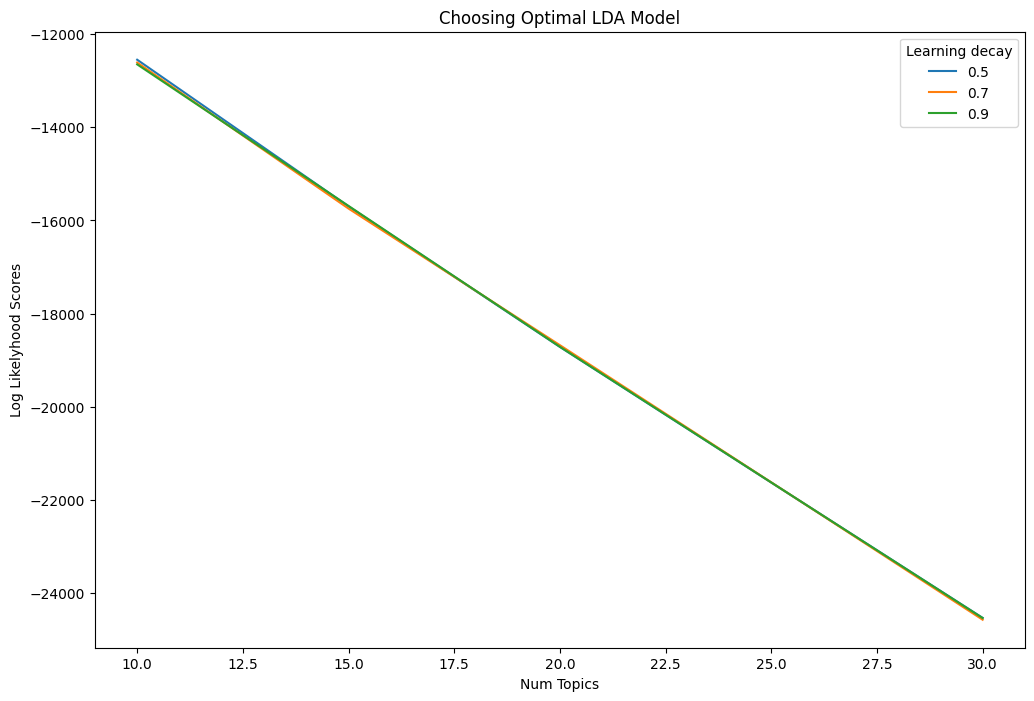

In [130]:
# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [131]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.940000,0.010000,0.010000,0.010000,6
Doc1,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.940000,0.010000,0.010000,0.010000,6
Doc2,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.940000,0.010000,0.010000,0.010000,6
Doc3,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.940000,0.010000,0.010000,0.010000,6
Doc4,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.940000,0.010000,0.010000,0.010000,6
Doc5,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.940000,0.010000,0.010000,0.010000,6
Doc6,0.000000,0.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
Doc7,0.000000,0.000000,0.000000,0.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3
Doc8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.990000,0.000000,0.000000,7
Doc9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.990000,9


In [132]:
df = df.set_index(df_document_topics.index)

In [133]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,6,9
1,1,4
2,3,2
3,7,2
4,9,2
5,2,2
6,5,2
7,8,1
8,0,1


In [134]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names_out()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,aapl,aapl said,aapl said tuesday,abates,abates global,abates global central,able,able access,able access images,abuse,...,york times said,young,young black,young black legislators,zoom,zoom roughly,zoom roughly thirds,zurich,zurich switzerland,zurich switzerland march
Topic0,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
Topic1,1.1,1.1,1.1,1.1,1.1,1.1,0.1,0.1,0.1,1.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,1.1,1.1,1.1
Topic2,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
Topic3,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
Topic4,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


In [135]:
# Show top 15 keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = []
    
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords["Topic"]= [str(i+1) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords["keywords"]=topic_keywords
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Topic,keywords
0,tennessee,president,representatives,state,demonstration,nashville,vice president,tennessee state,vice,president kamala harris,president kamala,harris,kamala,kamala harris,vice president kamala,1,"[tennessee, president, representatives, state,..."
1,apple,things,things watching,listening,watching,reading,reading listening,things watching reading,watching reading listening,watching reading,times,group,banks,crisis,bank,2,"[apple, things, things watching, listening, wa..."
2,report,paramount,noggin,stake,global,rates,reported,paramount global,learning,stake noggin,sale,wall street,street,wall,company,3,"[report, paramount, noggin, stake, global, rat..."
3,workers,israeli,friday,employers,lebanon,aviv,killed,tensions,gaza,west,union,labor,according,coast,week,4,"[workers, israeli, friday, employers, lebanon,..."
4,jones,jones products products,featuresadsmoredow jones products,jones products,servicetools featuresadsmoredow jones,featuresadsmoredow jones,servicetools,servicetools featuresadsmoredow,featuresadsmoredow,membershipcustomer,products products,membershipcustomer servicetools,membershipcustomer servicetools featuresadsmor...,products,friday,5,"[jones, jones products products, featuresadsmo..."
5,labor,unemployment,month,rates,federal reserve,reserve,market,federal,inflation,labor market,unemployment rate,track raise rates,rate,raise,high,6,"[labor, unemployment, month, rates, federal re..."
6,products,products products,featuresadsmoredow jones products,featuresadsmoredow jones,featuresadsmoredow,servicetools featuresadsmoredow jones,servicetools featuresadsmoredow,servicetools,jones products,jones products products,membershipcustomer servicetools featuresadsmor...,membershipcustomer servicetools,membershipcustomer,jones,said,7,"[products, products products, featuresadsmored..."
7,tesla,lawsuit,friday,thursday,thomas,federal,francisco,employees,justice,trips,supreme,decades,crow,disclosure,court,8,"[tesla, lawsuit, friday, thursday, thomas, fed..."
8,representatives,came,house,democratic,justin,control,protest,tennessee,jones,week,house representatives,latest,thursday,including,shooting,9,"[representatives, came, house, democratic, jus..."
9,rose,federal reserve,reserve,data,federal,workers,banks,roughly,roughly thirds,eligible workers,organizing,startup,eligible,cards,eligible workers signed,10,"[rose, federal reserve, reserve, data, federal..."


In [136]:
df1=df_document_topics.data

In [137]:
df1.columns

Index(['Topic0', 'Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5', 'Topic6',
       'Topic7', 'Topic8', 'Topic9', 'dominant_topic'],
      dtype='object')

In [138]:
df['Topics']=df1['dominant_topic']
df['Topics']

Doc0     6
Doc1     6
Doc2     6
Doc3     6
Doc4     6
Doc5     6
Doc6     1
Doc7     3
Doc8     7
Doc9     9
Doc10    2
Doc11    5
Doc12    5
Doc13    6
Doc14    6
Doc15    3
Doc16    1
Doc17    9
Doc18    6
Doc19    8
Doc20    0
Doc21    7
Doc22    1
Doc23    2
Doc24    1
Name: Topics, dtype: int64

In [139]:
df.head()

,title,date,author,content,url,content_preprocessed,summary,sentiment_scores,sentiment_label,cleaned,Topics
Doc0,None,None,None,WSJ MembershipCustomer ServiceTools & Features...,https://www.wsj.com/articles/a-great-man-got-a...,"[input_ids, attention_mask]",wsj membershipcustomer servicetools & features...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,membershipcustomer servicetools featuresadsmor...,6
Doc1,None,None,None,WSJ MembershipCustomer ServiceTools & Features...,https://www.wsj.com/articles/these-tech-worker...,"[input_ids, attention_mask]",wsj membershipcustomer servicetools & features...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,membershipcustomer servicetools featuresadsmor...,6
Doc2,None,None,None,WSJ MembershipCustomer ServiceTools & Features...,https://www.wsj.com/articles/uber-ceo-started-...,"[input_ids, attention_mask]",wsj membershipcustomer servicetools & features...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,membershipcustomer servicetools featuresadsmor...,6
Doc3,None,None,None,WSJ MembershipCustomer ServiceTools & Features...,https://www.wsj.com/video/series/on-the-news/d...,"[input_ids, attention_mask]",wsj membershipcustomer servicetools & features...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,membershipcustomer servicetools featuresadsmor...,6
Doc4,None,None,None,WSJ MembershipCustomer ServiceTools & Features...,https://www.wsj.com/video/series/travel-guides...,"[input_ids, attention_mask]",wsj membershipcustomer servicetools & features...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,membershipcustomer servicetools featuresadsmor...,6


In [140]:
df_topic_keywords['Topics']=df_topic_keywords['Topic']

In [141]:
df.rename(columns={"Final Topic":'Final_Topic'},inplace=True)
df_topic_keywords.rename(columns={"Final_Topic":'Final_Topic_1'},inplace=True)

In [142]:
df_topic_keywords['Topics']=df_topic_keywords['Topics'].astype(int)
df['Topics']=df['Topics'].astype(int)

In [143]:
data_2=pd.merge(df,df_topic_keywords[['Topics','keywords']],left_on = 'Topics',right_on= 'Topics',how='left')

In [144]:
data_2.tail()

,title,date,author,content,url,content_preprocessed,summary,sentiment_scores,sentiment_label,cleaned,Topics,keywords
20,"Harris backs expelled Tennessee lawmakers, chi...",None,None,[1/7] U.S. Vice President Kamala Harris speaks...,https://www.reuters.com/article/tennessee-poli...,"[input_ids, attention_mask]",[ 1 / 7 ] u. s. vice president kamala harris s...,"{'neg': 0.102, 'neu': 0.84, 'pos': 0.058, 'com...",negative,vice president kamala harris speaks address te...,0,NaN
21,U.S. Supreme Court Justice Thomas defends trip...,None,None,April 7 (Reuters) - U.S. Supreme Court Justice...,https://www.reuters.com/article/usa-court-just...,"[input_ids, attention_mask]",april 7 ( reuters ) - u. s. supreme court just...,"{'neg': 0.0, 'neu': 0.86, 'pos': 0.14, 'compou...",positive,supreme court justice clarence thomas friday d...,7,"[products, products products, featuresadsmored..."
22,"Unstable markets drag Canadian M&A, debt issua...",None,None,"TORONTO, April 6 (Reuters) - Canadian dealmake...",https://www.reuters.com/article/canada-deals/u...,"[input_ids, attention_mask]","toronto, april 6 ( reuters ) - canadian dealma...","{'neg': 0.145, 'neu': 0.761, 'pos': 0.094, 'co...",negative,toronto canadian dealmakers optimistic return ...,1,"[tennessee, president, representatives, state,..."
23,Paramount explores sale of majority stake in s...,None,None,April 7 (Reuters) - Paramount Global (PARA.O) ...,https://www.reuters.com/article/paramount-nogg...,"[input_ids, attention_mask]",april 7 ( reuters ) - paramount global ( para....,"{'neg': 0.0, 'neu': 0.926, 'pos': 0.074, 'comp...",positive,paramount global para exploring sale majority ...,2,"[apple, things, things watching, listening, wa..."
24,UBS CEO tells Credit Suisse staff to stay focu...,None,None,"[1/2] Sergio Ermotti, newly rehired CEO of UBS...",https://www.reuters.com/article/global-banks-c...,"[input_ids, attention_mask]","[ 1 / 2 ] sergio ermotti, newly rehired ceo of...","{'neg': 0.057, 'neu': 0.879, 'pos': 0.063, 'co...",positive,sergio ermotti newly rehired group attends new...,1,"[tennessee, president, representatives, state,..."


In [145]:
# Define function to run the pipeline
def run_pipeline():
    # Run the web scraper
    process = CrawlerProcess(get_project_settings())
    process.crawl(MySpider)
    process.start()

    # Load the scraped data into a dataframe
    new_data = pd.read_csv('data.csv')

    # Generate summaries for the new data
    new_data['summary'] = new_data['text'].apply(summarize_text)

    # Combine the new data with the existing data
    all_data = pd.concat([data, new_data])

    # Perform sentiment analysis on the summaries
    vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=2)
    data_vectorized = vectorizer.fit_transform(all_data['summary'])
    lda_model = LatentDirichletAllocation(n_components=3, random_state=42)
    lda_model.fit(data_vectorized)
    lda_output = lda_model.transform(data_vectorized)
    all_data['sentiment_label'], all_data['sentiment_scores'] = zip(*all_data['summary'].apply(analyze_sentiment))

    # Visualize the topics and sentiment scores
    panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
    pyLDAvis.save_html(panel, 'panel.html')
    print('Pipeline run complete.')

In [146]:
# Define the main function that runs the pipeline
def main():
    # Run the web scraper
    df = web_scraper()

    # Update the data analysis and insights
    update_insights(df)

In [147]:
# Use the schedule library to run the main function periodically
schedule.every(24).hours.do(main)

Every 24 hours do main() (last run: [never], next run: 2023-04-09 12:44:00)

In [148]:
# Use a try-except block to handle any exceptions that occur during execution
try:
    while True:
        schedule.run_pending()
        time.sleep(1)
except Exception as e:
    print("An error occurred: {}".format(str(e)))

KeyboardInterrupt: 